# GAT Model Evaluation

In [29]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from preprocessing.featurisation import get_atom_features, get_bond_features
from preprocessing.fetch_smiles import resolve_smiles_by_cas_interactive
from preprocessing.smiles_to_graph import batch_from_csv

In [30]:
graph_list = batch_from_csv('data/processed/input.csv')
molecules_df = pd.read_csv('data/processed/input.csv')

In [31]:
num_node_features = graph_list[0].num_node_features
num_edge_features = graph_list[0].num_edge_features
avg_degree = 2*(graph_list[0].num_edges) / graph_list[0].num_nodes
print(f"Number of node features: {num_node_features}")
print(f"Average degree of the graph: {avg_degree:.2f}") # From the avg. degree we can use at least 4 GCNConv layers
print(f"Number of edge features: {num_edge_features}")


Number of node features: 79
Average degree of the graph: 4.00
Number of edge features: 10


In [32]:
from torch_geometric.loader import DataLoader
batch = DataLoader(graph_list, batch_size=32, shuffle=True)

In [33]:
import torch
import random
import numpy as np

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(123)


In [34]:
from torch.nn import MSELoss
from torch_geometric.loader import DataLoader

train_loader = DataLoader(graph_list, batch_size=32, shuffle=True)


def train_gat_model(dataloader, model, lr=1e-3, epochs=300):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = MSELoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch).squeeze()
            target = batch.y.squeeze()

            assert out.shape == target.shape, f"{out.shape=} vs {target.shape=}"
            loss = loss_fn(out, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
    
    return model



In [35]:
from torch_geometric.nn import GATConv, global_mean_pool
from torch.nn import Sequential, Linear, ReLU, Dropout

class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_dim=1, dropout_rate=0.2):
        super().__init__()

        self.conv1 = GATConv(in_channels, hidden_dim, heads=2, concat=False)
        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = global_mean_pool(x, batch)
        return self.ffnn(x)

model = GATModel(num_node_features, hidden_dim=64, out_dim=1)
print(model)

GATModel(
  (conv1): GATConv(79, 64, heads=2)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [36]:
train_gat_model(graph_list, model, lr=1e-3, epochs=300)

Epoch 1, Loss: 2734.0041
Epoch 2, Loss: 2477.9604
Epoch 3, Loss: 2342.0819
Epoch 4, Loss: 2225.3175
Epoch 5, Loss: 2165.6438
Epoch 6, Loss: 2038.1685
Epoch 7, Loss: 1950.3030
Epoch 8, Loss: 1937.4774
Epoch 9, Loss: 1726.4223
Epoch 10, Loss: 1668.0831
Epoch 11, Loss: 1586.4072
Epoch 12, Loss: 1463.3252
Epoch 13, Loss: 1456.2165
Epoch 14, Loss: 1366.3378
Epoch 15, Loss: 1409.3900
Epoch 16, Loss: 1369.9573
Epoch 17, Loss: 1387.4749
Epoch 18, Loss: 1429.8262
Epoch 19, Loss: 1460.2270
Epoch 20, Loss: 1248.8125
Epoch 21, Loss: 1339.6761
Epoch 22, Loss: 1224.6626
Epoch 23, Loss: 1325.7309
Epoch 24, Loss: 1198.3082
Epoch 25, Loss: 1236.0700
Epoch 26, Loss: 1288.7677
Epoch 27, Loss: 1264.3957
Epoch 28, Loss: 1276.9834
Epoch 29, Loss: 1248.9332
Epoch 30, Loss: 1236.9986
Epoch 31, Loss: 1265.6206
Epoch 32, Loss: 1148.4739
Epoch 33, Loss: 1253.8290
Epoch 34, Loss: 1177.5217
Epoch 35, Loss: 1193.6891
Epoch 36, Loss: 1263.1080
Epoch 37, Loss: 1132.2503
Epoch 38, Loss: 1141.8196
Epoch 39, Loss: 1217.

GATModel(
  (conv1): GATConv(79, 64, heads=2)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [37]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt


def plot_predictions(model, loader):
    """
    Function to plot predictions vs actual values without scaling.
    """
    all_preds = [] 
    all_targets = []

    model.eval()
    with torch.no_grad():
        for batch in loader:
            preds = model(batch.x, batch.edge_index, batch.batch)
            # all_preds.append(preds.squeeze())
            # all_targets.append(batch.y.squeeze())
            all_preds.append(preds.view(-1))     # ensures [N]
            all_targets.append(batch.y.view(-1)) # ensures [N]

    all_preds = torch.cat(all_preds).cpu().numpy()
    all_targets = torch.cat(all_targets).cpu().numpy()

    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))

    print(f"R² score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")

    plt.figure(figsize=(6, 6))
    plt.scatter(all_targets, all_preds, alpha=0.7)
    plt.plot([all_targets.min(), all_targets.max()], 
             [all_targets.min(), all_targets.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Predicted vs. Actual - GAT Model (Batched)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

R² score: 0.909
RMSE: 1.708


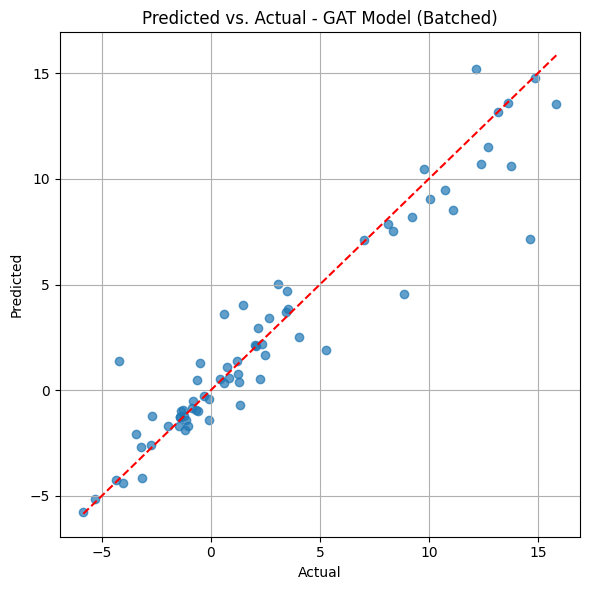

In [38]:
plot_predictions(model, train_loader)

In [39]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
import torch

def plot_predictions_plotly(dataloader, model, metadata_df=None):
    """
    Function to plot predictions vs actual values using Plotly with hover tooltips.
    
    metadata_df: Optional DataFrame with molecule metadata.
                 Should have at least as many rows as total predictions.
                 Example columns: MoleculeName, SMILES, CAS.
    """
    all_preds = []
    all_targets = []

    # Put model in eval mode
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            preds = model(batch.x, batch.edge_index, batch.batch).squeeze()
            targets = batch.y.squeeze()

            if preds.dim() == 0:
                preds = preds.unsqueeze(0)
            if targets.dim() == 0:
                targets = targets.unsqueeze(0)

            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    # Flatten
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Compute metrics
    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))

    print(f"R² score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")

    # Build DataFrame
    df = pd.DataFrame({
        "Actual": all_targets,
        "Predicted": all_preds
    })

    # Merge metadata if available
    if metadata_df is not None:
        metadata_df = metadata_df.reset_index(drop=True)
        df = pd.concat([df, metadata_df.iloc[:len(df)].reset_index(drop=True)], axis=1)

    # Make plot
    fig = px.scatter(
        df,
        x="Actual",
        y="Predicted",
        hover_data={
            "Inhibitor Name": True,
            "Inh Power": False, #':.2f',
            "CAS Number": False,
            "SMILES": False
        },
        title="Predicted vs Actual - GAT Model (Batched)",
        labels={"Actual": "Actual", "Predicted": "Predicted"},
        height=600,
        width=600
    )

    # Identity line y=x
    fig.add_shape(
        type="line",
        x0=df["Actual"].min(),
        y0=df["Actual"].min(),
        x1=df["Actual"].max(),
        y1=df["Actual"].max(),
        line=dict(color="red", dash="dash"),
    )

    fig.update_traces(marker=dict(size=8, opacity=0.7))
    fig.update_layout(showlegend=False)
    fig.show()


In [40]:
eval_loader = DataLoader(graph_list, batch_size=32, shuffle=False)
plot_predictions_plotly(eval_loader, model, metadata_df=molecules_df)

R² score: 0.909
RMSE: 1.708


In [81]:
import torch
import umap
import pandas as pd
import plotly.express as px

# Store everything
all_embeddings = []
all_labels = []

# Model in eval mode
model.eval()
with torch.no_grad():
    for batch in eval_loader:
        emb = model(batch.x, batch.edge_index, batch=batch.batch)
        all_embeddings.append(emb.cpu())
        all_labels.append(batch.y.cpu())

# Stack them
embeddings = torch.cat(all_embeddings, dim=0).numpy()  # shape: (70, hidden_dim)
labels = torch.cat(all_labels, dim=0).numpy()          # shape: (70,)


In [82]:
embeddings.shape, labels.shape

((70, 1), (70,))

In [83]:
# Create 2D embeddings for plotly plot
reducer = umap.UMAP(n_components=2, random_state=123)
embeddings_2d = reducer.fit_transform(embeddings)



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [84]:
df = pd.DataFrame({
    "UMAP1": embeddings_2d[:,0],
    "UMAP2": embeddings_2d[:,1],
    "Label": labels
})

# If you also have names/SMILES:
df["Inhibitor"] = molecules_df["Inhibitor Name"]
df

,UMAP1,UMAP2,Label,Inhibitor
0,5.873487,11.481932,5.29,1-H-imidazole-2-carboxylic acid
1,3.693882,5.632165,10.04,1-methyl-1-H-benzimidazole-2-thiol
2,6.461776,10.957861,-0.51,1-methyl-benzimidazole
3,5.791119,11.187475,2.09,"1,2,4-triazole"
4,4.431259,12.033614,3.54,"1,3-diisopropyl-2-thiourea"
...,...,...,...,...
65,6.656595,11.137907,1.19,Thiosalycylic acid
66,4.463603,11.862889,2.68,Thiourea
67,-5.294053,12.920834,-0.88,Triisoproponalamine
68,-7.535732,11.404039,-5.85,Tryptamine


In [85]:
fig = px.scatter(
    df,
    x="UMAP1",
    y="UMAP2",
    color="Label",
    hover_data={
        "Inhibitor": True,
        "Label": ':.2f'
    },
    title="UMAP projection of GNN graph embeddings"
)
fig.show()


## Predicting an arbitrary molecule

In [41]:
mol_to_predict = [graph_list[23]]
mol_to_predict[0].y

tensor([1.2800])

In [42]:
from torch_geometric.data import Batch

def predict_single_molecule(model, molecule_graph):
    model.eval()
    with torch.no_grad():
        batch = Batch.from_data_list([molecule_graph])  # wrap in a list

        prediction = model(
            batch.x, batch.edge_index, batch.batch
        )

        return round(prediction.item(), 4) 
predicted_value = predict_single_molecule(model, mol_to_predict[0])
predicted_value

0.386

## Effect of Training Parameters on model performance

Here, we will explore the effects of model training parameters (and small model changes) and how these affect model performance. Namely, we will explore the effects of:
* Number of layers used within the model
* Number of epochs used in training
* Learning rate
* Dropout rate


### Number of Layers

#### 2 Layers

In [72]:
import torch
from torch_geometric.nn import GATConv, global_mean_pool
from torch.nn import Sequential, Linear, ReLU, Dropout

class GATModel2L(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_dim=1, dropout_rate=0.2):
        super().__init__()

        self.conv1 = GATConv(in_channels, hidden_dim, heads=2, concat=False)
        self.conv2 = GATConv(hidden_dim, hidden_dim, heads=2, concat=False)
        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = global_mean_pool(x, batch)
        return self.ffnn(x)



In [73]:
model_2L = GATModel2L(num_node_features, hidden_dim=64, out_dim=1)
print(model_2L)

GATModel2L(
  (conv1): GATConv(79, 64, heads=2)
  (conv2): GATConv(64, 64, heads=2)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


Epoch 1, Loss: 95.6292
Epoch 2, Loss: 115.2311
Epoch 3, Loss: 107.6964
Epoch 4, Loss: 123.4092
Epoch 5, Loss: 109.5562
Epoch 6, Loss: 86.6838
Epoch 7, Loss: 104.3386
Epoch 8, Loss: 112.6823
Epoch 9, Loss: 93.2478
Epoch 10, Loss: 124.2533
Epoch 11, Loss: 80.6006
Epoch 12, Loss: 118.0674
Epoch 13, Loss: 100.9763
Epoch 14, Loss: 77.7931
Epoch 15, Loss: 90.2170
Epoch 16, Loss: 70.9269
Epoch 17, Loss: 77.7466
Epoch 18, Loss: 98.5747
Epoch 19, Loss: 106.2492
Epoch 20, Loss: 86.6708
Epoch 21, Loss: 129.2853
Epoch 22, Loss: 71.2432
Epoch 23, Loss: 76.9970
Epoch 24, Loss: 88.6767
Epoch 25, Loss: 84.0371
Epoch 26, Loss: 102.6496
Epoch 27, Loss: 94.7354
Epoch 28, Loss: 84.6694
Epoch 29, Loss: 96.0167
Epoch 30, Loss: 93.3800
Epoch 31, Loss: 80.7593
Epoch 32, Loss: 83.2871
Epoch 33, Loss: 108.6825
Epoch 34, Loss: 67.2674
Epoch 35, Loss: 82.0209
Epoch 36, Loss: 71.5528
Epoch 37, Loss: 80.5898
Epoch 38, Loss: 78.3862
Epoch 39, Loss: 76.6925
Epoch 40, Loss: 76.5047
Epoch 41, Loss: 82.3908
Epoch 42, Lo

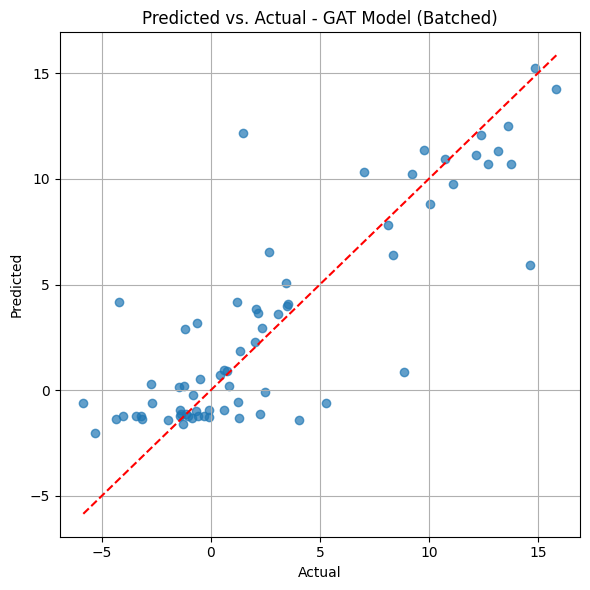

In [74]:
train_gat_model(train_loader, model_2L, lr=1e-3, epochs=300)
plot_predictions(model_2L, train_loader)

#### 3 Layers

In [ ]:
import torch
from torch_geometric.nn import GATConv, global_mean_pool
from torch.nn import Sequential, Linear, ReLU, Dropout

class GATModel3L(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_dim=1, dropout_rate=0.2):
        super().__init__()

        self.conv1 = GATConv(in_channels, hidden_dim, heads=2, concat=False)
        self.conv2 = GATConv(hidden_dim, hidden_dim, heads=2, concat=False)
        self.conv3 = GATConv(hidden_dim, hidden_dim, heads=2, concat=False)
        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = global_mean_pool(x, batch)
        return self.ffnn(x)



In [ ]:
model_3L = GATModel3L(num_node_features, hidden_dim=64, out_dim=1)
print(model_3L)

GATModel2(
  (conv1): GATConv(79, 64, heads=2)
  (conv2): GATConv(64, 64, heads=2)
  (conv3): GATConv(64, 64, heads=2)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


Epoch 1, Loss: 104.1126
Epoch 2, Loss: 123.6004
Epoch 3, Loss: 105.1820
Epoch 4, Loss: 98.6648
Epoch 5, Loss: 123.9155
Epoch 6, Loss: 109.4530
Epoch 7, Loss: 118.9214
Epoch 8, Loss: 122.5209
Epoch 9, Loss: 91.6614
Epoch 10, Loss: 114.7800
Epoch 11, Loss: 110.5817
Epoch 12, Loss: 96.8741
Epoch 13, Loss: 101.0712
Epoch 14, Loss: 88.8921
Epoch 15, Loss: 95.2755
Epoch 16, Loss: 91.7186
Epoch 17, Loss: 73.1596
Epoch 18, Loss: 101.9755
Epoch 19, Loss: 88.5431
Epoch 20, Loss: 91.1425
Epoch 21, Loss: 86.6618
Epoch 22, Loss: 85.2082
Epoch 23, Loss: 96.7701
Epoch 24, Loss: 93.4019
Epoch 25, Loss: 94.3209
Epoch 26, Loss: 95.7838
Epoch 27, Loss: 94.3283
Epoch 28, Loss: 88.3009
Epoch 29, Loss: 82.9186
Epoch 30, Loss: 79.0607
Epoch 31, Loss: 79.8366
Epoch 32, Loss: 107.7752
Epoch 33, Loss: 90.3213
Epoch 34, Loss: 71.9092
Epoch 35, Loss: 64.7773
Epoch 36, Loss: 66.6774
Epoch 37, Loss: 74.2696
Epoch 38, Loss: 74.6102
Epoch 39, Loss: 61.3941
Epoch 40, Loss: 83.7292
Epoch 41, Loss: 64.3018
Epoch 42, Los

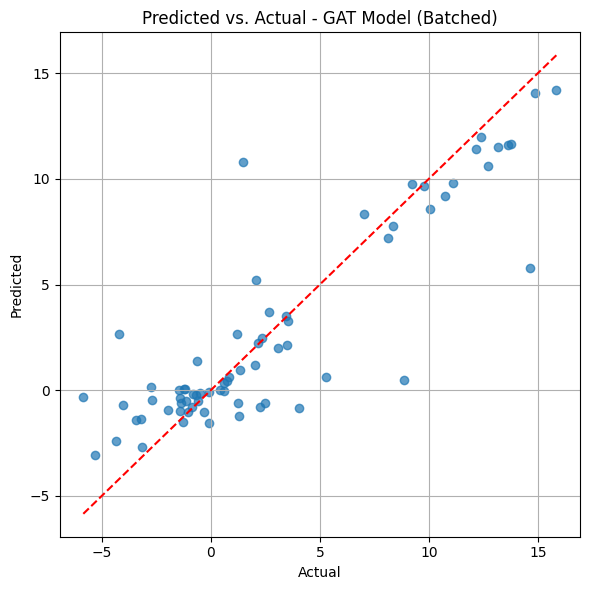

In [ ]:
train_gat_model(train_loader, model_3L, lr=1e-3, epochs=300)
plot_predictions(model_3L, train_loader)

In [44]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import torch

def r2_rmse(dataloader, model):
    """
    Function to plot predictions vs actual values.
    This function however returns the R² score and RMSE.
    """
    all_preds = [] 
    all_targets = []

    # Put model in evaluation mode
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            preds = model(batch.x, batch.edge_index, batch.batch).squeeze()
            targets = batch.y.squeeze()

            # Handle possible shape mismatches
            if preds.dim() == 0:
                preds = preds.unsqueeze(0)
            if targets.dim() == 0:
                targets = targets.unsqueeze(0)

            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Compute metrics
    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))

    print(f"R² score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")
    
    return r2, rmse

### Number of Epochs

In [59]:
train_epochs = [100, 200, 300, 400, 500]
metrics_epoch = {}
for epoch in train_epochs:
    gat_model = GATModel(in_channels=num_node_features, hidden_dim=64, out_dim=1)
    train_gat_model(train_loader, gat_model, lr=1e-3, epochs=epoch)
    metrics_epoch[epoch] = r2_rmse(train_loader, gat_model)
metrics_epoch

Epoch 1, Loss: 119.3077
Epoch 2, Loss: 90.6154
Epoch 3, Loss: 96.1118
Epoch 4, Loss: 91.4051
Epoch 5, Loss: 135.5547
Epoch 6, Loss: 164.4607
Epoch 7, Loss: 96.6192
Epoch 8, Loss: 148.0725
Epoch 9, Loss: 141.1985
Epoch 10, Loss: 122.7059
Epoch 11, Loss: 105.0998
Epoch 12, Loss: 116.6657
Epoch 13, Loss: 81.7514
Epoch 14, Loss: 86.5082
Epoch 15, Loss: 96.4031
Epoch 16, Loss: 109.0286
Epoch 17, Loss: 160.5802
Epoch 18, Loss: 96.0912
Epoch 19, Loss: 130.9819
Epoch 20, Loss: 76.5096
Epoch 21, Loss: 105.7716
Epoch 22, Loss: 104.2770
Epoch 23, Loss: 98.4902
Epoch 24, Loss: 94.6928
Epoch 25, Loss: 99.9048
Epoch 26, Loss: 110.7621
Epoch 27, Loss: 109.0416
Epoch 28, Loss: 91.9344
Epoch 29, Loss: 113.3974
Epoch 30, Loss: 81.1544
Epoch 31, Loss: 91.6960
Epoch 32, Loss: 107.8364
Epoch 33, Loss: 82.1084
Epoch 34, Loss: 86.0971
Epoch 35, Loss: 108.7049
Epoch 36, Loss: 104.6469
Epoch 37, Loss: 95.0783
Epoch 38, Loss: 88.9260
Epoch 39, Loss: 106.2524
Epoch 40, Loss: 83.1894
Epoch 41, Loss: 104.8608
Epoc

{100: (0.4590455889701843, np.float64(4.1648374484101645)),
 200: (0.5332057476043701, np.float64(3.8688375632586784)),
 300: (0.5822238922119141, np.float64(3.6600707867557016)),
 400: (0.6326037645339966, np.float64(3.432298782796627)),
 500: (0.693950355052948, np.float64(3.1326631810093875))}

In [60]:
for key,value in metrics_epoch.items():
    print(f"Epochs: {key}, R²: {value[0]:.3f}, RMSE: {value[1]:.3f}")

Epochs: 100, R²: 0.459, RMSE: 4.165
Epochs: 200, R²: 0.533, RMSE: 3.869
Epochs: 300, R²: 0.582, RMSE: 3.660
Epochs: 400, R²: 0.633, RMSE: 3.432
Epochs: 500, R²: 0.694, RMSE: 3.133


### Dropout Rates

In [46]:
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
metrics_dropouts = {}

for dr in dropout_rates:
    model_dr = GATModel(in_channels=num_node_features, hidden_dim=64, out_dim=1, dropout_rate=dr)
    train_gat_model(train_loader, model_dr, epochs=300, lr=1e-3)
    metrics_dropouts[dr] = r2_rmse(train_loader, model_dr)
metrics_dropouts

Epoch 1, Loss: 120.1386
Epoch 2, Loss: 115.0068
Epoch 3, Loss: 107.1985
Epoch 4, Loss: 148.4405
Epoch 5, Loss: 106.7204
Epoch 6, Loss: 100.1680
Epoch 7, Loss: 122.1340
Epoch 8, Loss: 130.5709
Epoch 9, Loss: 103.0797
Epoch 10, Loss: 84.5962
Epoch 11, Loss: 85.7878
Epoch 12, Loss: 105.7962
Epoch 13, Loss: 97.2741
Epoch 14, Loss: 121.0961
Epoch 15, Loss: 95.3960
Epoch 16, Loss: 100.1309
Epoch 17, Loss: 117.5111
Epoch 18, Loss: 128.1077
Epoch 19, Loss: 115.4759
Epoch 20, Loss: 87.8384
Epoch 21, Loss: 86.8083
Epoch 22, Loss: 84.2525
Epoch 23, Loss: 83.1222
Epoch 24, Loss: 102.9637
Epoch 25, Loss: 100.0437
Epoch 26, Loss: 104.6318
Epoch 27, Loss: 99.8017
Epoch 28, Loss: 87.5225
Epoch 29, Loss: 107.8053
Epoch 30, Loss: 88.2372
Epoch 31, Loss: 88.1608
Epoch 32, Loss: 82.5165
Epoch 33, Loss: 91.2718
Epoch 34, Loss: 81.9361
Epoch 35, Loss: 89.9689
Epoch 36, Loss: 107.2306
Epoch 37, Loss: 77.1911
Epoch 38, Loss: 74.1163
Epoch 39, Loss: 91.9799
Epoch 40, Loss: 94.9002
Epoch 41, Loss: 104.2008
Epoc

{0.1: (0.6731160879135132, np.float64(3.2375351951777525)),
 0.2: (0.6293555498123169, np.float64(3.4474383864730394)),
 0.3: (0.6024059057235718, np.float64(3.5705709217796664)),
 0.4: (0.5776566863059998, np.float64(3.6800229836865728)),
 0.5: (0.5841405391693115, np.float64(3.6516660989830263))}

In [57]:
for key, value in metrics_dropouts.items():
    print(f"Dropout Rate: {key}, R²: {value[0]:.3f}, RMSE: {value[1]:.3f}")

Dropout Rate: 0.1, R²: 0.673, RMSE: 3.238
Dropout Rate: 0.2, R²: 0.629, RMSE: 3.447
Dropout Rate: 0.3, R²: 0.602, RMSE: 3.571
Dropout Rate: 0.4, R²: 0.578, RMSE: 3.680
Dropout Rate: 0.5, R²: 0.584, RMSE: 3.652


### Learning rate

In [61]:
lrs = [1e-1 ,1e-2 ,1e-3, 1e-4, 1e-5, 1e-6]
metrics_learnRate = {}

for lr in lrs:
    model_lr = GATModel(in_channels=num_node_features, hidden_dim=64, out_dim=1)
    train_gat_model(train_loader, model_lr, epochs=300, lr=lr)
    metrics_learnRate[lr] = r2_rmse(train_loader, model_lr)
    print(f"Learning Rate: {lr}, R²: {metrics_learnRate[lr][0]:.3f}, RMSE: {metrics_learnRate[lr][1]:.3f}")

Epoch 1, Loss: 135.9688
Epoch 2, Loss: 92.0356
Epoch 3, Loss: 96.4504
Epoch 4, Loss: 86.3396
Epoch 5, Loss: 105.2262
Epoch 6, Loss: 77.4668
Epoch 7, Loss: 69.9967
Epoch 8, Loss: 94.0210
Epoch 9, Loss: 83.2542
Epoch 10, Loss: 63.2169
Epoch 11, Loss: 64.4182
Epoch 12, Loss: 74.2680
Epoch 13, Loss: 81.2738
Epoch 14, Loss: 82.4847
Epoch 15, Loss: 72.3664
Epoch 16, Loss: 68.0433
Epoch 17, Loss: 66.2918
Epoch 18, Loss: 65.1781
Epoch 19, Loss: 55.3951
Epoch 20, Loss: 41.3134
Epoch 21, Loss: 37.0708
Epoch 22, Loss: 46.0649
Epoch 23, Loss: 80.4956
Epoch 24, Loss: 52.1632
Epoch 25, Loss: 49.9019
Epoch 26, Loss: 54.5727
Epoch 27, Loss: 51.7972
Epoch 28, Loss: 62.1134
Epoch 29, Loss: 31.8134
Epoch 30, Loss: 34.9891
Epoch 31, Loss: 55.3729
Epoch 32, Loss: 70.8077
Epoch 33, Loss: 42.1998
Epoch 34, Loss: 44.3834
Epoch 35, Loss: 41.8914
Epoch 36, Loss: 40.0277
Epoch 37, Loss: 35.6292
Epoch 38, Loss: 46.6110
Epoch 39, Loss: 42.4359
Epoch 40, Loss: 51.0504
Epoch 41, Loss: 32.9377
Epoch 42, Loss: 32.4066

In [56]:
for key,value in metrics_learnRate.items():
    print(f"Learning Rate: {key}, R²: {value[0]:.3f}, RMSE: {value[1]:.3f}")

Learning Rate: 0.1, R²: 0.687, RMSE: 3.167
Learning Rate: 0.01, R²: 0.789, RMSE: 2.603
Learning Rate: 0.001, R²: 0.614, RMSE: 3.517
Learning Rate: 0.0001, R²: 0.087, RMSE: 5.411
Learning Rate: 1e-05, R²: -0.192, RMSE: 6.183
Learning Rate: 1e-06, R²: -0.257, RMSE: 6.350
